# Exploration of Student Dropout and Academic Success data



In [1]:
# 1) Import Python Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import sparse
import IPython.display as disp

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN  # Added for advanced sampling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support as score,
    roc_auc_score,  # Added for ROC-AUC
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
import xgboost as xgb  # Added for XGBoost
import shap  # Added for SHAP analysis
import optuna  # Added for hyperparameter tuning

In [2]:
# 2) Define Utility Functions
def show_value_counts_in_table(data, columns, limit=10):
    value_counts_table = pd.DataFrame()
    for col in columns:
        counts = data[col].value_counts().reset_index()
        counts.columns = [col, 'Count']
        value_counts_table = pd.concat([value_counts_table, counts], axis=1)
    value_counts_table = value_counts_table.head(limit).fillna("")
    disp.display(disp.HTML(value_counts_table.to_html()))

def show_value_percent_in_table(data, columns, limit=10):
    value_percs_table = pd.DataFrame()
    for col in columns:
        percs = data[col].value_counts(normalize=True).reset_index()
        percs.columns = [col, '%']
        percs['%'] = (percs['%'] * 100).round(2)
        value_percs_table = pd.concat([value_percs_table, percs], axis=1)
    value_percs_table = value_percs_table.head(limit).fillna("")
    disp.display(disp.HTML(value_percs_table.to_html()))

def show_data_in_table(data):
    dataCopy = pd.DataFrame(data)
    dataCopy.insert(0, "Row", range(1, len(dataCopy) + 1))
    html = dataCopy.to_html(classes="table table-striped", index=False)
    css = """
    <style>
        .dataframe {
            display: block;
            overflow-x: auto;
            max-height: 300px;
            border-collapse: collapse;
            width: 100%;
        }
        .dataframe th {
            position: sticky;
            top: 0;
            background-color: #f8f9fa;
            z-index: 2;
        }
        .dataframe td:first-child, .dataframe th:first-child {
            position: sticky;
            left: 0;
            background-color: #ffffff;
            z-index: 1;
        }
    </style>
    """
    disp.display(disp.HTML(css + html))

In [3]:
# 3) Data Preparation
# Import the data
data = pd.read_csv('students_dropout_and_academic_success.csv', sep=';')

# Improve column naming
data.rename(columns={'Nacionality': 'Nationality'}, inplace=True)
data.columns = data.columns.str.upper().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace("'S", '').str.replace('\\t', '').str.strip()

# Build lists of column types
categorical_columns = [
    'MARITAL_STATUS', 'APPLICATION_MODE', 'APPLICATION_ORDER', 'COURSE',
    'DAYTIME/EVENING_ATTENDANCE', 'PREVIOUS_QUALIFICATION', 'NATIONALITY',
    'MOTHER_QUALIFICATION', 'FATHER_QUALIFICATION', 'MOTHER_OCCUPATION',
    'FATHER_OCCUPATION', 'DISPLACED', 'EDUCATIONAL_SPECIAL_NEEDS', 'DEBTOR',
    'TUITION_FEES_UP_TO_DATE', 'GENDER', 'SCHOLARSHIP_HOLDER', 'INTERNATIONAL', 'TARGET'
]

continuous_columns = [
    'PREVIOUS_QUALIFICATION_GRADE', 'ADMISSION_GRADE', 'AGE_AT_ENROLLMENT',
    'CURRICULAR_UNITS_1ST_SEM_CREDITED', 'CURRICULAR_UNITS_1ST_SEM_ENROLLED',
    'CURRICULAR_UNITS_1ST_SEM_EVALUATIONS', 'CURRICULAR_UNITS_1ST_SEM_APPROVED',
    'CURRICULAR_UNITS_1ST_SEM_GRADE', 'CURRICULAR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS',
    'CURRICULAR_UNITS_2ND_SEM_CREDITED', 'CURRICULAR_UNITS_2ND_SEM_ENROLLED',
    'CURRICULAR_UNITS_2ND_SEM_EVALUATIONS', 'CURRICULAR_UNITS_2ND_SEM_APPROVED',
    'CURRICULAR_UNITS_2ND_SEM_GRADE', 'CURRICULAR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS',
    'UNEMPLOYMENT_RATE', 'INFLATION_RATE', 'GDP'
]

In [4]:
# Feature Engineering: Add new features
data['GRADE_DIFF_SEM1_SEM2'] = data['CURRICULAR_UNITS_1ST_SEM_GRADE'] - data['CURRICULAR_UNITS_2ND_SEM_GRADE']
data['ACADEMIC_LOAD_SEM1'] = data['CURRICULAR_UNITS_1ST_SEM_CREDITED'] + data['CURRICULAR_UNITS_1ST_SEM_ENROLLED']
data['ACADEMIC_LOAD_SEM2'] = data['CURRICULAR_UNITS_2ND_SEM_CREDITED'] + data['CURRICULAR_UNITS_2ND_SEM_ENROLLED']

# Update continuous columns
continuous_columns.extend(['GRADE_DIFF_SEM1_SEM2', 'ACADEMIC_LOAD_SEM1', 'ACADEMIC_LOAD_SEM2'])

In [5]:
# Validate categorical data
print("NaN Counts by column")
print("--------------------")
print(data[categorical_columns].isnull().sum())

print("\nUnique values by column")
print("-----------------------")
for col in categorical_columns:
    print(f"Unique values and counts for '{col}':")
    print(data[col].value_counts())
    print("\n")

# Validate continuous data
print("NaN Counts by column")
print("--------------------")
print(data[continuous_columns].isnull().sum())

print("\nCheck for infinite values")
inf_rows_count = data[continuous_columns].isin([np.inf, -np.inf]).any(axis=1).sum()
if inf_rows_count == 0:
    print("Data validated: No infinite values found.")
else:
    print("Data Quality error: Infinite values found in the data.")

NaN Counts by column
--------------------
MARITAL_STATUS                0
APPLICATION_MODE              0
APPLICATION_ORDER             0
COURSE                        0
DAYTIME/EVENING_ATTENDANCE    0
PREVIOUS_QUALIFICATION        0
NATIONALITY                   0
MOTHER_QUALIFICATION          0
FATHER_QUALIFICATION          0
MOTHER_OCCUPATION             0
FATHER_OCCUPATION             0
DISPLACED                     0
EDUCATIONAL_SPECIAL_NEEDS     0
DEBTOR                        0
TUITION_FEES_UP_TO_DATE       0
GENDER                        0
SCHOLARSHIP_HOLDER            0
INTERNATIONAL                 0
TARGET                        0
dtype: int64

Unique values by column
-----------------------
Unique values and counts for 'MARITAL_STATUS':
MARITAL_STATUS
1    3919
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64


Unique values and counts for 'APPLICATION_MODE':
APPLICATION_MODE
1     1708
17     872
39     785
43     312
44     213
7      139
18    

In [6]:
# Check GRADE values for out-of-range issues
assert data['PREVIOUS_QUALIFICATION_GRADE'].between(0, 200).all(), "Data Error: PREVIOUS_QUALIFICATION_GRADE values are out of range."
assert data['ADMISSION_GRADE'].between(0, 200).all(), "Data Error: ADMISSION_GRADE values are out of range."
assert data['CURRICULAR_UNITS_1ST_SEM_GRADE'].between(0, 20).all(), "Data Error: CURRICULAR_UNITS_1ST_SEM_GRADE values are out of range."
assert data['CURRICULAR_UNITS_2ND_SEM_GRADE'].between(0, 20).all(), "Data Error: CURRICULAR_UNITS_2ND_SEM_GRADE values are out of range."

In [7]:
# Drop rows with no unit enrollment in the 1st semester
rows_count_before = data.shape[0]
data = data.drop(data[data['CURRICULAR_UNITS_1ST_SEM_ENROLLED'] == 0].index)
rows_count_after = data.shape[0]
print(f"Dropped {rows_count_before - rows_count_after} rows")

Dropped 180 rows


In [8]:
# 4) Feature Creation
# Create AGE_GROUP_AT_ENROLLMENT feature
bins = [0, 18, 20, 30, float('inf')]
labels = ['Under 19', '19-20', '21-30', 'Over 30']
data['AGE_GROUP_AT_ENROLLMENT'] = pd.cut(data['AGE_AT_ENROLLMENT'], bins=bins, labels=labels).astype(str)
categorical_columns.append('AGE_GROUP_AT_ENROLLMENT')

# Display the distribution of age groups
age_counts = data['AGE_GROUP_AT_ENROLLMENT'].value_counts().reset_index()
age_counts.columns = ['AGE_GROUP_AT_ENROLLMENT', 'Count']
print(age_counts)

  AGE_GROUP_AT_ENROLLMENT  Count
0                   19-20   1437
1                   21-30   1174
2                Under 19    978
3                 Over 30    655


In [9]:
# 5) Machine Learning Setup
# Redefine categorical and continuous columns for machine learning
categorical_columns_for_ML = [
    'MARITAL_STATUS', 'APPLICATION_MODE', 'APPLICATION_ORDER', 'COURSE',
    'DAYTIME/EVENING_ATTENDANCE', 'PREVIOUS_QUALIFICATION', 'NATIONALITY',
    'MOTHER_QUALIFICATION', 'FATHER_QUALIFICATION', 'MOTHER_OCCUPATION',
    'FATHER_OCCUPATION', 'DISPLACED', 'EDUCATIONAL_SPECIAL_NEEDS', 'DEBTOR',
    'TUITION_FEES_UP_TO_DATE', 'GENDER', 'SCHOLARSHIP_HOLDER', 'INTERNATIONAL'
]

continuous_columns_for_ML = [
    'PREVIOUS_QUALIFICATION_GRADE', 'ADMISSION_GRADE', 'AGE_AT_ENROLLMENT',
    'CURRICULAR_UNITS_1ST_SEM_CREDITED', 'CURRICULAR_UNITS_1ST_SEM_ENROLLED',
    'CURRICULAR_UNITS_1ST_SEM_EVALUATIONS', 'CURRICULAR_UNITS_1ST_SEM_APPROVED',
    'CURRICULAR_UNITS_1ST_SEM_GRADE', 'CURRICULAR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS',
    'CURRICULAR_UNITS_2ND_SEM_CREDITED', 'CURRICULAR_UNITS_2ND_SEM_ENROLLED',
    'CURRICULAR_UNITS_2ND_SEM_EVALUATIONS', 'CURRICULAR_UNITS_2ND_SEM_APPROVED',
    'CURRICULAR_UNITS_2ND_SEM_GRADE', 'CURRICULAR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS',
    'UNEMPLOYMENT_RATE', 'INFLATION_RATE', 'GDP', 'GRADE_DIFF_SEM1_SEM2',
    'ACADEMIC_LOAD_SEM1', 'ACADEMIC_LOAD_SEM2'
]

In [10]:
# Split predictors from response variable (TARGET)
X = data.drop(columns='TARGET')
Y = data['TARGET']

In [11]:
# Check target distribution
target_count = Y.value_counts()
print("Target distribution:")
print(target_count)

Target distribution:
TARGET
Graduate    2134
Dropout     1344
Enrolled     766
Name: count, dtype: int64


In [12]:
# Initialize dictionary and list to store experiment results
index = []
scores = {"Accuracy": [], "Balanced accuracy": [], "ROC-AUC": [], "F1-Macro": []}

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [14]:
# Verify stratified split
print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True))


Training set target distribution:
TARGET
Graduate    0.502798
Dropout     0.316642
Enrolled    0.180560
Name: proportion, dtype: float64

Test set target distribution:
TARGET
Graduate    0.502945
Dropout     0.316843
Enrolled    0.180212
Name: proportion, dtype: float64


In [15]:
# 6) Baseline Model (Dummy Classifier)
index.append("Dummy classifier")
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

In [16]:
# Evaluate baseline model
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)

In [17]:
# Ensure all keys in scores have the same length
for key in scores:
	if len(scores[key]) < len(index):
		scores[key].extend([None] * (len(index) - len(scores[key])))

# Display baseline results
df_scores = pd.DataFrame(scores, index=index)
print("\nBaseline model results:")
print(df_scores)


Baseline model results:
                  Accuracy  Balanced accuracy ROC-AUC F1-Macro
Dummy classifier  0.502945           0.333333    None     None


In [18]:
# 7) Logistic Regression with Preprocessing
# Preprocessing continuous columns
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train[continuous_columns_for_ML])
X_test_cont_scaled = scaler.transform(X_test[continuous_columns_for_ML])

# Preprocessing categorical columns
encoder_cat = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = encoder_cat.fit_transform(X_train[categorical_columns_for_ML])
X_test_cat_encoded = encoder_cat.transform(X_test[categorical_columns_for_ML])

# Combine continuous and categorical preprocessed columns
X_train_preprocessed = np.hstack((X_train_cont_scaled, X_train_cat_encoded))
X_test_preprocessed = np.hstack((X_test_cont_scaled, X_test_cat_encoded))

# Fit Logistic Regression model
lr_clf = LogisticRegression(max_iter=500, random_state=99)
lr_clf.fit(X_train_preprocessed, y_train)

# Predict and evaluate
y_pred_lr = lr_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred_lr)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_lr)
y_prob_lr = lr_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
precision, recall, fscore, _ = score(y_test, y_pred_lr, average='macro')

# Append results
index.append("Logistic Regression")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nLogistic Regression results:")
print(df_scores)


Logistic Regression results:
                     Accuracy  Balanced accuracy   ROC-AUC  F1-Macro
Dummy classifier     0.502945           0.333333       NaN       NaN
Logistic Regression  0.796231           0.713977  0.891524  0.726752


In [19]:
# 8) Random Forest with Preprocessing
# Fit Random Forest model
rf_clf = RandomForestClassifier(random_state=99, n_jobs=-1)
rf_clf.fit(X_train_preprocessed, y_train)

# Predict and evaluate
y_pred_rf = rf_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred_rf)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_rf)
y_prob_rf = rf_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
precision, recall, fscore, _ = score(y_test, y_pred_rf, average='macro')

# Append results
index.append("Random Forest")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nRandom Forest results:")
print(df_scores)


Random Forest results:
                     Accuracy  Balanced accuracy   ROC-AUC  F1-Macro
Dummy classifier     0.502945           0.333333       NaN       NaN
Logistic Regression  0.796231           0.713977  0.891524  0.726752
Random Forest        0.787986           0.694119  0.890671  0.712003


In [20]:
# 9) Advanced Sampling (SMOTEENN)
# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=99)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_preprocessed, y_train)

# Fit Logistic Regression with SMOTEENN
lr_clf_smote_enn = LogisticRegression(max_iter=500, random_state=99)
lr_clf_smote_enn.fit(X_train_smote_enn, y_train_smote_enn)

# Predict and evaluate
y_pred_lr_smote_enn = lr_clf_smote_enn.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred_lr_smote_enn)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_lr_smote_enn)
y_prob_lr_smote_enn = lr_clf_smote_enn.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_prob_lr_smote_enn, multi_class='ovr')
precision, recall, fscore, _ = score(y_test, y_pred_lr_smote_enn, average='macro')

# Append results
index.append("Logistic Regression with SMOTEENN")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nLogistic Regression with SMOTEENN results:")
print(df_scores)


Logistic Regression with SMOTEENN results:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Regression with SMOTEENN  0.660873  


In [21]:
# 10) XGBoost Integration
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit XGBoost model
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=99)
xgb_clf.fit(X_train_preprocessed, y_train_encoded)

# Predict and evaluate
y_pred_xgb = xgb_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test_encoded, y_pred_xgb)
test_balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_xgb)
y_prob_xgb = xgb_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test_encoded, y_prob_xgb, multi_class='ovr')
precision, recall, fscore, _ = score(y_test_encoded, y_pred_xgb, average='macro')

# Append results
index.append("XGBoost")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nXGBoost results:")
print(df_scores)


XGBoost results:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   
XGBoost                            0.793875           0.719473  0.888588   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Regression with SMOTEENN  0.660873  
XGBoost                            0.730548  


In [22]:
# # 11) SHAP Analysis for Interpretability
# # Explain Random Forest predictions using SHAP
# explainer_rf = shap.TreeExplainer(rf_clf)
# shap_values_rf = explainer_rf.shap_values(X_test_preprocessed)

# # Summary plot for Random Forest
# shap.summary_plot(shap_values_rf, X_test_preprocessed, feature_names=encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML)



In [23]:
# # Explain XGBoost predictions using SHAP
# explainer_xgb = shap.TreeExplainer(xgb_clf)
# shap_values_xgb = explainer_xgb.shap_values(X_test_preprocessed)

# # Summary plot for XGBoost
# shap.summary_plot(shap_values_xgb, X_test_preprocessed, feature_names=encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML)

In [24]:
# 12) Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    model = xgb.XGBClassifier(**params, objective='multi:softmax', num_class=3, random_state=99)
    model.fit(X_train_preprocessed, y_train_encoded)
    y_pred = model.predict(X_test_preprocessed)
    return roc_auc_score(y_test_encoded, model.predict_proba(X_test_preprocessed), multi_class='ovr')

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Display best hyperparameters
print("Best hyperparameters for XGBoost:")
print(study.best_params)

[I 2025-02-24 18:54:09,661] A new study created in memory with name: no-name-079bcd6c-fe23-486c-84dc-cbc30a81b116
[I 2025-02-24 18:54:54,418] Trial 0 finished with value: 0.890616076971449 and parameters: {'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.09413334865284205, 'subsample': 0.6245864090898641, 'colsample_bytree': 0.7379867299208152}. Best is trial 0 with value: 0.890616076971449.
[I 2025-02-24 18:55:22,935] Trial 1 finished with value: 0.8856725175440651 and parameters: {'n_estimators': 497, 'max_depth': 13, 'learning_rate': 0.19435146451003524, 'subsample': 0.650616889078991, 'colsample_bytree': 0.6089689761543869}. Best is trial 0 with value: 0.890616076971449.
[I 2025-02-24 18:55:41,127] Trial 2 finished with value: 0.8826973589861433 and parameters: {'n_estimators': 252, 'max_depth': 15, 'learning_rate': 0.2834281995087964, 'subsample': 0.7707294244393879, 'colsample_bytree': 0.6681608234758173}. Best is trial 0 with value: 0.890616076971449.
[I 2025-02-24 18:55

Best hyperparameters for XGBoost:
{'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.09413334865284205, 'subsample': 0.6245864090898641, 'colsample_bytree': 0.7379867299208152}


In [25]:
# Fit XGBoost with best hyperparameters
best_xgb_clf = xgb.XGBClassifier(**study.best_params, objective='multi:softmax', num_class=3, random_state=99)
best_xgb_clf.fit(X_train_preprocessed, y_train_encoded)

# Predict and evaluate
y_pred_best_xgb = best_xgb_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test_encoded, y_pred_best_xgb)
test_balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_best_xgb)
y_prob_best_xgb = best_xgb_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test_encoded, y_prob_best_xgb, multi_class='ovr')
precision, recall, fscore, _ = score(y_test_encoded, y_pred_best_xgb, average='macro')

# Append results
index.append("XGBoost (Optuna Tuned)")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nXGBoost (Optuna Tuned) results:")
print(df_scores)


XGBoost (Optuna Tuned) results:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   
XGBoost                            0.793875           0.719473  0.888588   
XGBoost (Optuna Tuned)             0.778563           0.700915  0.890616   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Regression with SMOTEENN  0.660873  
XGBoost                            0.730548  
XGBoost (Optuna Tuned)             0.712195  


In [26]:
# 13) Decision Trees and Grid Search
# Fit Decision Tree model
tree_clf = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=99)
tree_clf.fit(X_train_preprocessed, y_train)

# Predict and evaluate
y_pred_tree = tree_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred_tree)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_tree)
y_prob_tree = tree_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_prob_tree, multi_class='ovr')
precision, recall, fscore, _ = score(y_test, y_pred_tree, average='macro')

# Append results
index.append("Decision Tree")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nDecision Tree results:")
print(df_scores)


Decision Tree results:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   
XGBoost                            0.793875           0.719473  0.888588   
XGBoost (Optuna Tuned)             0.778563           0.700915  0.890616   
Decision Tree                      0.729093           0.642752  0.843790   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Regression with SMOTEENN  0.660873  
XGBoost                            0.730548  
XGBoost (Optuna Tuned)             0.712195  
Decision Tree                      0.653398  

In [27]:
# Grid Search for Decision Tree
params_tree = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'criterion': ['entropy', 'gini']
}

gs_tree = GridSearchCV(tree_clf, params_tree, cv=5, scoring='f1_macro', n_jobs=-1)
gs_tree_fit = gs_tree.fit(X_train_preprocessed, y_train)

# Display best parameters
print("Best parameters for Decision Tree:")
print(gs_tree_fit.best_params_)

# Fit Decision Tree with best parameters
best_tree_clf = DecisionTreeClassifier(**gs_tree_fit.best_params_, random_state=99)
best_tree_clf.fit(X_train_preprocessed, y_train)

# Predict and evaluate
y_pred_best_tree = best_tree_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred_best_tree)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_best_tree)
y_prob_best_tree = best_tree_clf.predict_proba(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_prob_best_tree, multi_class='ovr')
precision, recall, fscore, _ = score(y_test, y_pred_best_tree, average='macro')

# Append results
index.append("Decision Tree (Grid Search Tuned)")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
scores["ROC-AUC"].append(roc_auc)
scores["F1-Macro"].append(fscore)

# Display results
df_scores = pd.DataFrame(scores, index=index)
print("\nDecision Tree (Grid Search Tuned) results:")
print(df_scores)

Best parameters for Decision Tree:
{'criterion': 'entropy', 'max_depth': 6}

Decision Tree (Grid Search Tuned) results:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   
XGBoost                            0.793875           0.719473  0.888588   
XGBoost (Optuna Tuned)             0.778563           0.700915  0.890616   
Decision Tree                      0.729093           0.642752  0.843790   
Decision Tree (Grid Search Tuned)  0.753828           0.652569  0.850293   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Re

In [28]:
# 14) Final Model Comparison and Results
# Display final comparison of all models
print("\nFinal Model Comparison:")
print(df_scores)


Final Model Comparison:
                                   Accuracy  Balanced accuracy   ROC-AUC  \
Dummy classifier                   0.502945           0.333333       NaN   
Logistic Regression                0.796231           0.713977  0.891524   
Random Forest                      0.787986           0.694119  0.890671   
Logistic Regression with SMOTEENN  0.677267           0.690819  0.872684   
XGBoost                            0.793875           0.719473  0.888588   
XGBoost (Optuna Tuned)             0.778563           0.700915  0.890616   
Decision Tree                      0.729093           0.642752  0.843790   
Decision Tree (Grid Search Tuned)  0.753828           0.652569  0.850293   

                                   F1-Macro  
Dummy classifier                        NaN  
Logistic Regression                0.726752  
Random Forest                      0.712003  
Logistic Regression with SMOTEENN  0.660873  
XGBoost                            0.730548  
XGBoost (Optun

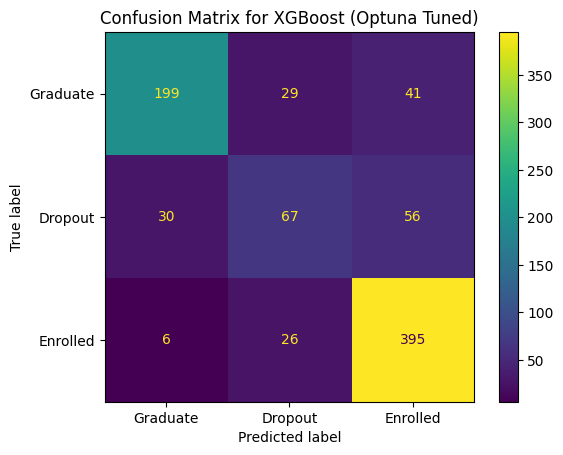

In [29]:
# Generate confusion matrix for the best model (XGBoost with Optuna tuning)
y_pred_best_xgb_labels = label_encoder.inverse_transform(y_pred_best_xgb)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_xgb_labels, display_labels=['Graduate', 'Dropout', 'Enrolled'])
plt.title("Confusion Matrix for XGBoost (Optuna Tuned)")
plt.show()

In [30]:
# Classification report for the best model
y_pred_best_xgb_labels = label_encoder.inverse_transform(y_pred_best_xgb)
print("\nClassification Report for XGBoost (Optuna Tuned):")
print(classification_report(y_test, y_pred_best_xgb_labels, target_names=['Graduate', 'Dropout', 'Enrolled']))


Classification Report for XGBoost (Optuna Tuned):
              precision    recall  f1-score   support

    Graduate       0.85      0.74      0.79       269
     Dropout       0.55      0.44      0.49       153
    Enrolled       0.80      0.93      0.86       427

    accuracy                           0.78       849
   macro avg       0.73      0.70      0.71       849
weighted avg       0.77      0.78      0.77       849



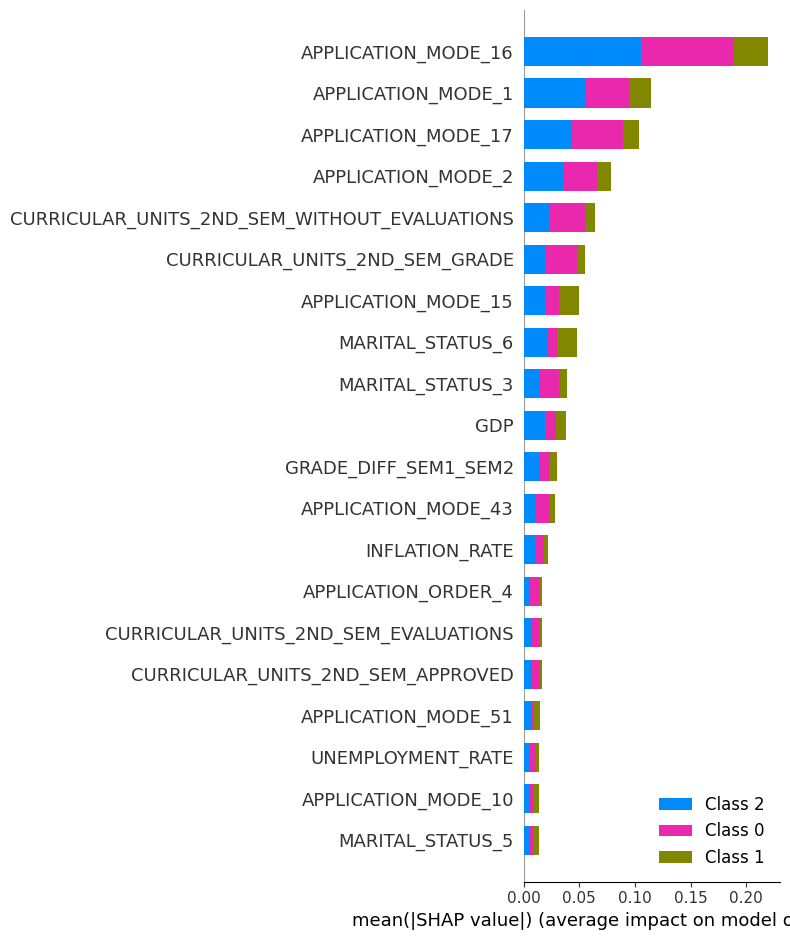

In [31]:
# Explain Random Forest predictions using SHAP
explainer_rf = shap.TreeExplainer(rf_clf)
shap_values_rf = explainer_rf.shap_values(X_test_preprocessed)

# Ensure shap_values_rf is a list of arrays (one for each class)
if isinstance(shap_values_rf, np.ndarray) and shap_values_rf.ndim == 3:
	shap_values_rf = [shap_values_rf[:, :, i] for i in range(shap_values_rf.shape[2])]

# Summary plot for Random Forest
shap.summary_plot(shap_values_rf, X_test_preprocessed, feature_names=encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML)


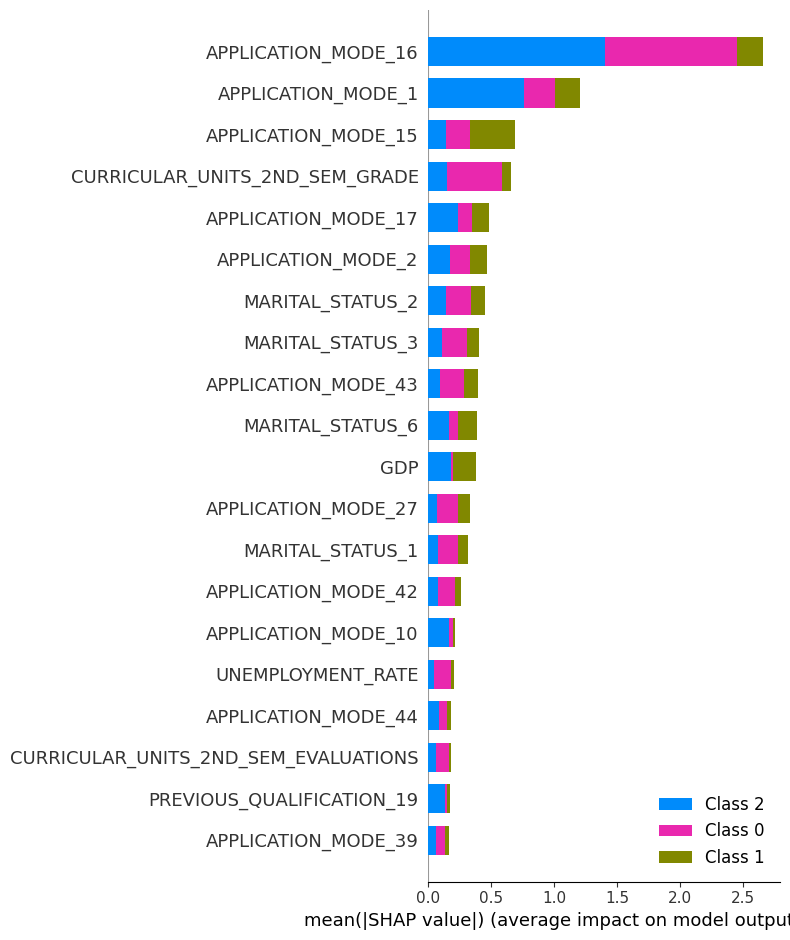

In [32]:

# Explain XGBoost predictions using SHAP
explainer_xgb = shap.TreeExplainer(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(X_test_preprocessed)

# Ensure shap_values_xgb is a list of arrays (one for each class)
if isinstance(shap_values_xgb, np.ndarray) and shap_values_xgb.ndim == 3:
	shap_values_xgb = [shap_values_xgb[:, :, i] for i in range(shap_values_xgb.shape[2])]

# Summary plot for XGBoost
shap.summary_plot(shap_values_xgb, X_test_preprocessed, feature_names=encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML)

<Figure size 1000x800 with 0 Axes>

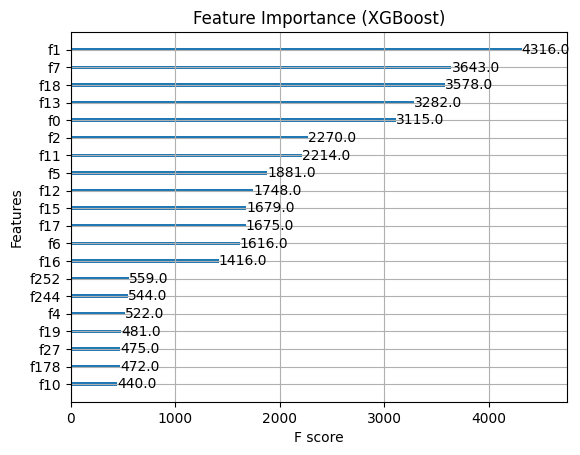

In [33]:
# 15) Feature Importance Visualization

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb_clf, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (XGBoost)")
plt.show()



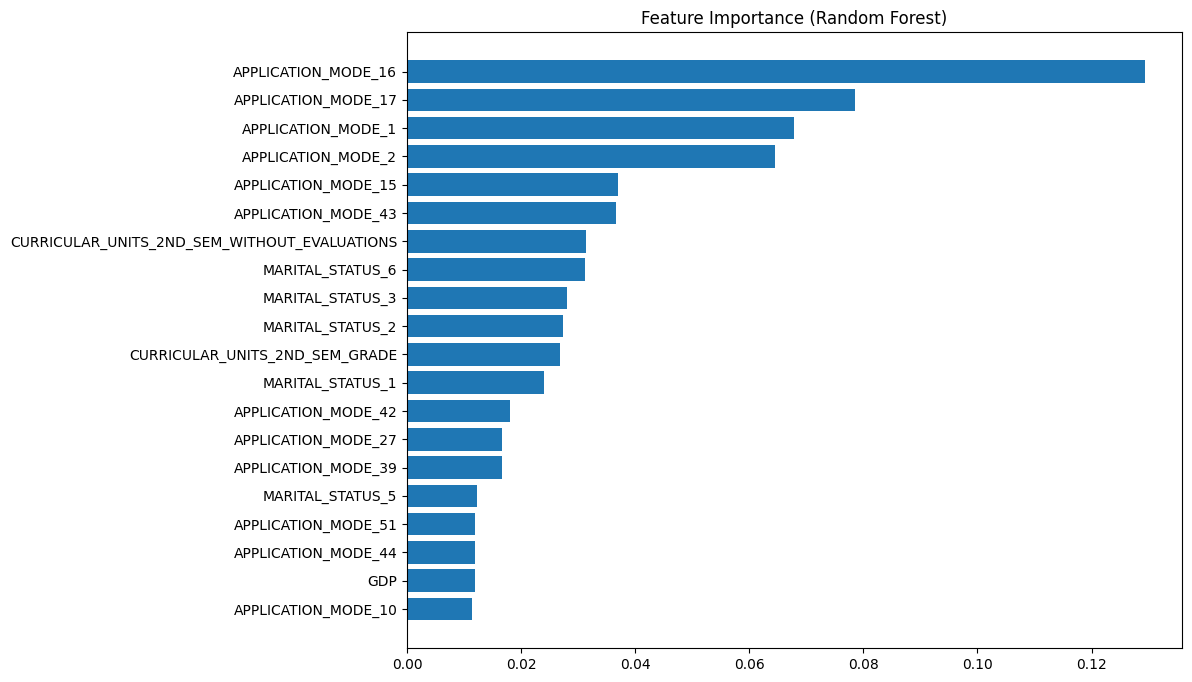

In [34]:
# Plot feature importance for Random Forest
importances = rf_clf.feature_importances_
feature_names = encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML
sorted_idx = np.argsort(importances)[-20:]  # Top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.show()

In [35]:
# 16) Cross-Validation for Robust Evaluation
# Define a function for cross-validation
def cross_validate_model(model, X, y, cv=5):
    scoring = {
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'roc_auc_ovr': 'roc_auc_ovr',
        'f1_macro': 'f1_macro'
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        'accuracy': cv_results['test_accuracy'].mean(),
        'balanced_accuracy': cv_results['test_balanced_accuracy'].mean(),
        'roc_auc': cv_results['test_roc_auc_ovr'].mean(),
        'f1_macro': cv_results['test_f1_macro'].mean()
    }



In [36]:
from sklearn.model_selection import cross_validate

# Encode target variable for cross-validation
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Perform cross-validation for XGBoost
xgb_cv_results = cross_validate_model(best_xgb_clf, X_train_preprocessed, y_train_encoded, cv=5)
print("\nCross-Validation Results for XGBoost:")
print(xgb_cv_results)




Cross-Validation Results for XGBoost:
{'accuracy': 0.7843888070692193, 'balanced_accuracy': 0.7027524945802225, 'roc_auc': 0.8943539980771475, 'f1_macro': 0.7131103278601173}


In [37]:
# Perform cross-validation for Random Forest
rf_cv_results = cross_validate_model(rf_clf, X_train_preprocessed, y_train, cv=5)
print("\nCross-Validation Results for Random Forest:")
print(rf_cv_results)


Cross-Validation Results for Random Forest:
{'accuracy': 0.7835051546391752, 'balanced_accuracy': 0.685409285772199, 'roc_auc': 0.889674799850947, 'f1_macro': 0.6961563050533132}


In [38]:
# 17) Model Interpretability with LIME
# Install LIME if not already installed

# %pip install lime

import lime
import lime.lime_tabular

# Create a LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_preprocessed,
    feature_names=encoder_cat.get_feature_names_out().tolist() + continuous_columns_for_ML,
    class_names=['Graduate', 'Dropout', 'Enrolled'],
    mode='classification'
)

# Explain a single prediction (e.g., the first test sample)
exp = explainer_lime.explain_instance(X_test_preprocessed[0], best_xgb_clf.predict_proba, num_features=10)
exp.show_in_notebook()

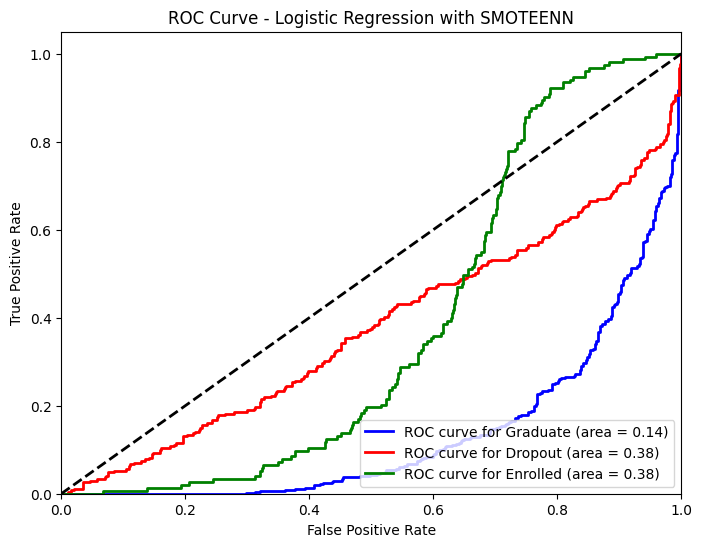

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# plot ROC curve

# Binarize the true labels for multiclass ROC curve calculation
classes = ['Graduate', 'Dropout', 'Enrolled']
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class using y_prob_lr_smote_enn
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_lr_smote_enn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with SMOTEENN')
plt.legend(loc="lower right")
plt.show()

In [40]:
# %pip install lightgbm
# %pip install catboost

import lightgbm as lgb
from catboost import CatBoostClassifier

# Implement LightGBM and CatBoost boosting models and compare with XGBoost (Optuna Tuned)


# LightGBM model
lgb_clf = lgb.LGBMClassifier(random_state=99)
lgb_clf.fit(X_train_preprocessed, y_train_encoded)
y_pred_lgb = lgb_clf.predict(X_test_preprocessed)
y_prob_lgb = lgb_clf.predict_proba(X_test_preprocessed)
lgb_acc = accuracy_score(y_test_encoded, y_pred_lgb)
lgb_bal_acc = balanced_accuracy_score(y_test_encoded, y_pred_lgb)
lgb_roc_auc = roc_auc_score(y_test_encoded, y_prob_lgb, multi_class='ovr')
lgb_precision, lgb_recall, lgb_fscore, _ = score(y_test_encoded, y_pred_lgb, average='macro')

# CatBoost model
cat_clf = CatBoostClassifier(verbose=0, random_state=99)
cat_clf.fit(X_train_preprocessed, y_train_encoded)
y_pred_cat = cat_clf.predict(X_test_preprocessed)
y_prob_cat = cat_clf.predict_proba(X_test_preprocessed)
cat_acc = accuracy_score(y_test_encoded, y_pred_cat)
cat_bal_acc = balanced_accuracy_score(y_test_encoded, y_pred_cat)
cat_roc_auc = roc_auc_score(y_test_encoded, y_prob_cat, multi_class='ovr')
cat_precision, cat_recall, cat_fscore, _ = score(y_test_encoded, y_pred_cat, average='macro')

# XGBoost (Optuna Tuned) was fitted earlier and is stored in best_xgb_clf
y_pred_xgb = best_xgb_clf.predict(X_test_preprocessed)
y_prob_xgb = best_xgb_clf.predict_proba(X_test_preprocessed)
xgb_acc = accuracy_score(y_test_encoded, y_pred_xgb)
xgb_bal_acc = balanced_accuracy_score(y_test_encoded, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test_encoded, y_prob_xgb, multi_class='ovr')
xgb_precision, xgb_recall, xgb_fscore, _ = score(y_test_encoded, y_pred_xgb, average='macro')

# Create a comparison dataframe
comparison = pd.DataFrame({
    'Accuracy': [lgb_acc, cat_acc, xgb_acc],
    'Balanced Accuracy': [lgb_bal_acc, cat_bal_acc, xgb_bal_acc],
    'ROC-AUC': [lgb_roc_auc, cat_roc_auc, xgb_roc_auc],
    'F1-Macro': [lgb_fscore, cat_fscore, xgb_fscore]
}, index=['LightGBM', 'CatBoost', 'XGBoost (Optuna Tuned)'])

print("\nBoosting Models Comparison:")
print(comparison)

c:\Users\aidan_1k98io6\myenv\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 3395, number of used features: 125
[LightGBM] [Info] Start training from score -1.149983
[LightGBM] [Info] Start training from score -1.711694
[LightGBM] [Info] Start training from score -0.687566

Boosting Models Comparison:
                        Accuracy  Balanced Accuracy   ROC-AUC  F1-Macro
LightGBM                0.784452           0.705780  0.892087  0.716008
CatBoost                0.775029           0.688328  0.889647  0.699073
XGBoost (Optuna Tuned)  0.778563           0.700915  0.890616  0.712195


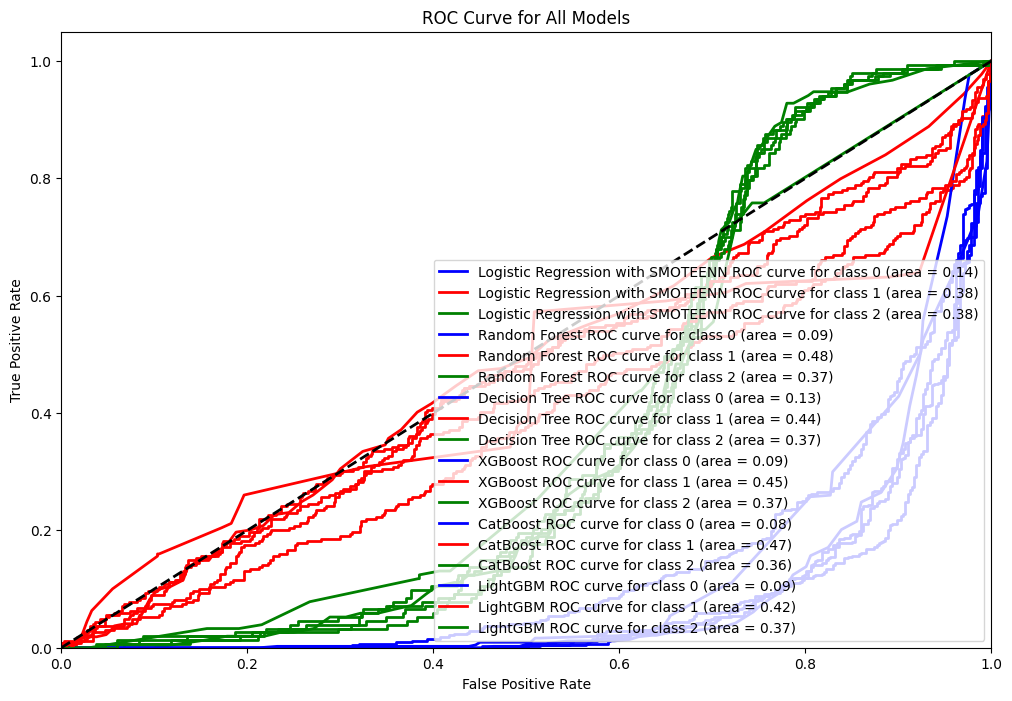

In [41]:
# ROC-AUC curve for all machine learning models

# Binarize the true labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=['Graduate', 'Dropout', 'Enrolled'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class and each model
fpr = dict()
tpr = dict()
roc_auc = dict()
models = {
    'Logistic Regression with SMOTEENN': y_prob_lr_smote_enn,
    'Random Forest': y_prob_rf,
    'Decision Tree': y_prob_best_tree,
    'XGBoost': y_prob_best_xgb,
    'CatBoost': y_prob_cat,
    'LightGBM': y_prob_lgb
}

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
for model_name, y_prob in models.items():
    for i in range(n_classes):
        fpr[model_name, i], tpr[model_name, i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[model_name, i] = auc(fpr[model_name, i], tpr[model_name, i])
        plt.plot(fpr[model_name, i], tpr[model_name, i], color=colors[i % len(colors)], lw=2,
                 label=f'{model_name} ROC curve for class {i} (area = {roc_auc[model_name, i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc="lower right")
plt.show()

In [42]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support as score

# Function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test):
    lr_clf = LogisticRegression(max_iter=500, random_state=99)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    y_prob = lr_clf.predict_proba(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    precision, recall, fscore, _ = score(y_test, y_pred, average='macro')
    
    return test_acc, test_balanced_acc, roc_auc, fscore

# Original data
results = {}
results['Original'] = evaluate_model(X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Random undersampling
rus = RandomUnderSampler(random_state=99)
X_train_rus, y_train_rus = rus.fit_resample(X_train_preprocessed, y_train)
results['Random Undersampling'] = evaluate_model(X_train_rus, y_train_rus, X_test_preprocessed, y_test)

# Random oversampling
ros = RandomOverSampler(random_state=99)
X_train_ros, y_train_ros = ros.fit_resample(X_train_preprocessed, y_train)
results['Random Oversampling'] = evaluate_model(X_train_ros, y_train_ros, X_test_preprocessed, y_test)

# SMOTE
smote = SMOTE(random_state=99)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
results['SMOTE'] = evaluate_model(X_train_smote, y_train_smote, X_test_preprocessed, y_test)

# SMOTEENN
smote_enn = SMOTEENN(random_state=99)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_preprocessed, y_train)
results['SMOTEENN'] = evaluate_model(X_train_smote_enn, y_train_smote_enn, X_test_preprocessed, y_test)

# Display results
df_results = pd.DataFrame(results, index=['Accuracy', 'Balanced Accuracy', 'ROC-AUC', 'F1-Macro']).T
print("\nComparison of Resampling Methods:")
print(df_results)


Comparison of Resampling Methods:
                      Accuracy  Balanced Accuracy   ROC-AUC  F1-Macro
Original              0.796231           0.713977  0.891524  0.726752
Random Undersampling  0.757362           0.721422  0.890197  0.715981
Random Oversampling   0.750294           0.710688  0.885442  0.706243
SMOTE                 0.751472           0.708672  0.886672  0.705019
SMOTEENN              0.677267           0.690819  0.872684  0.660873


In [43]:
from imblearn.over_sampling import ADASYN

# Compare SMOTE and ADASYN resampling methods

# SMOTE
smote = SMOTE(random_state=99)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
smote_results = evaluate_model(X_train_smote, y_train_smote, X_test_preprocessed, y_test)

# ADASYN
adasyn = ADASYN(random_state=99)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_preprocessed, y_train)
adasyn_results = evaluate_model(X_train_adasyn, y_train_adasyn, X_test_preprocessed, y_test)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'SMOTE': smote_results,
    'ADASYN': adasyn_results
}, index=['Accuracy', 'Balanced Accuracy', 'ROC-AUC', 'F1-Macro'])

print("Comparison of SMOTE vs ADASYN:")
print(comparison_df)

Comparison of SMOTE vs ADASYN:
                      SMOTE    ADASYN
Accuracy           0.751472  0.744405
Balanced Accuracy  0.708672  0.702065
ROC-AUC            0.886672  0.884597
F1-Macro           0.705019  0.698152


In [44]:
# PCA

# clustering (k-means)

# association rule mining

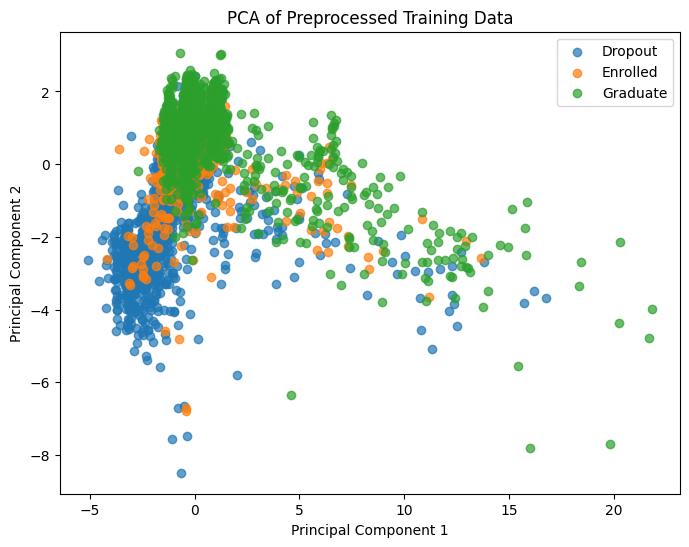

In [49]:
from sklearn.decomposition import PCA

# Perform PCA on the preprocessed training features
pca = PCA(n_components=2, random_state=99)
X_train_pca = pca.fit_transform(X_train_preprocessed)

# Plot the first two principal components with target labels
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = (y_train == label)
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Preprocessed Training Data")
plt.legend()
plt.show()

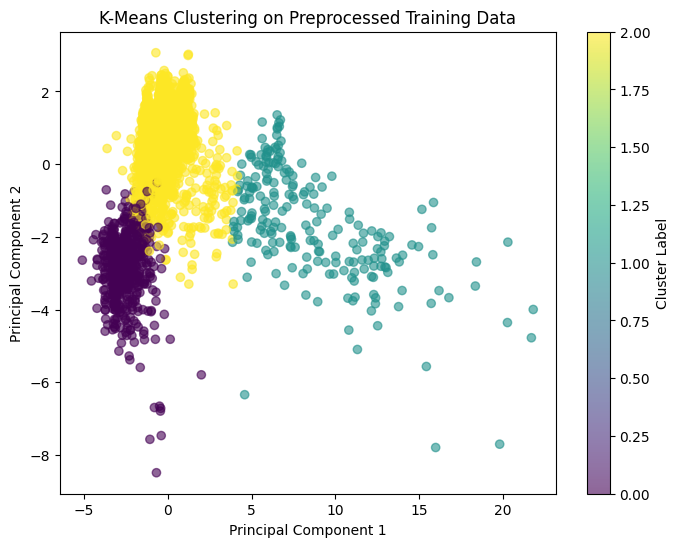

Cluster Distribution: {0: 569, 1: 217, 2: 2609}


In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set the number of clusters
n_clusters = 3

# Apply k-means clustering on the preprocessed training data
kmeans = KMeans(n_clusters=n_clusters, random_state=99)
clusters = kmeans.fit_predict(X_train_preprocessed)

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2, random_state=99)
X_train_pca = pca.fit_transform(X_train_preprocessed)

# Plot clusters in the PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering on Preprocessed Training Data")
plt.colorbar(label='Cluster Label')
plt.show()

# Print cluster distribution
unique, counts = np.unique(clusters, return_counts=True)
print("Cluster Distribution:", dict(zip(unique, counts)))

In [54]:
from mlxtend.frequent_patterns import apriori, association_rules

# Select a subset of categorical variables for association rule mining
assoc_columns = ['APPLICATION_MODE', 'COURSE', 'GENDER']  # Adjust as needed
basket = pd.get_dummies(data[assoc_columns].astype(str))

# Generate frequent itemsets with a minimum support of 0.1
frequent_itemsets = apriori(basket, min_support=0.1, use_colnames=True)

# Generate association rules with a confidence threshold of 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by lift in descending order and display the top rules
rules = rules.sort_values(by='lift', ascending=False)
print(rules.head())

             antecedents consequents  antecedent support  consequent support  \
2          (COURSE_9500)  (GENDER_0)            0.180490            0.657163   
0   (APPLICATION_MODE_1)  (GENDER_0)            0.375353            0.657163   
1  (APPLICATION_MODE_17)  (GENDER_0)            0.198633            0.657163   

    support  confidence      lift  representativity  leverage  conviction  \
2  0.145382    0.805483  1.225697               1.0  0.026770    1.762504   
0  0.274034    0.730069  1.110941               1.0  0.027366    1.270091   
1  0.140669    0.708185  1.077640               1.0  0.010135    1.174844   

   zhangs_metric   jaccard  certainty  kulczynski  
2       0.224693  0.210007   0.432625    0.513355  
0       0.159869  0.361292   0.212655    0.573532  
1       0.089904  0.196705   0.148823    0.461120  


C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\288591790.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_best_xgb[:, i], label=cls, shade=True)
C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\288591790.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_best_xgb[:, i], label=cls, shade=True)
C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\288591790.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_best_xgb[:, i], label=cls, shade=True)


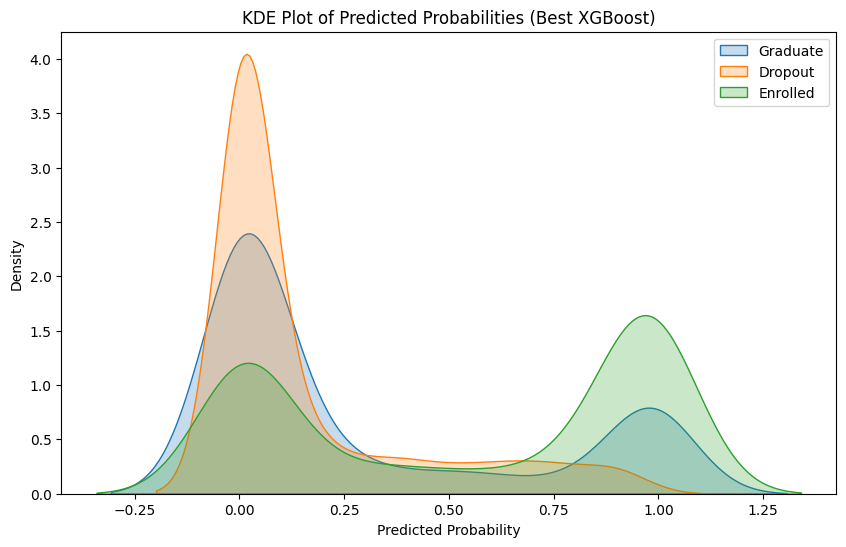

In [55]:
# KDE plots for predicted probabilities of Best XGBoost model for each class
plt.figure(figsize=(10, 6))
classes = ['Graduate', 'Dropout', 'Enrolled']
for i, cls in enumerate(classes):
    sns.kdeplot(y_prob_best_xgb[:, i], label=cls, shade=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('KDE Plot of Predicted Probabilities (Best XGBoost)')
plt.legend()
plt.show()

In [56]:
# Compute descriptive statistics for numerical features using the continuous_columns list
desc_stats = data[continuous_columns].describe(percentiles=[0.25, 0.5, 0.75])
print("Descriptive Statistics for Numerical Features:")
print(desc_stats)

# Although the 50% percentile in describe() is the median, we can print median separately if needed
median_vals = data[continuous_columns].median()
print("\nMedian values for Numerical Features:")
print(median_vals)

Descriptive Statistics for Numerical Features:
       PREVIOUS_QUALIFICATION_GRADE  ADMISSION_GRADE  AGE_AT_ENROLLMENT  \
count                   4244.000000      4244.000000        4244.000000   
mean                     132.373115       126.607163          23.397738   
std                       13.059485        14.281839           7.684054   
min                       95.000000        95.000000          17.000000   
25%                      124.000000       117.800000          19.000000   
50%                      133.000000       125.800000          20.000000   
75%                      140.000000       134.100000          25.000000   
max                      190.000000       190.000000          70.000000   

       CURRICULAR_UNITS_1ST_SEM_CREDITED  CURRICULAR_UNITS_1ST_SEM_ENROLLED  \
count                        4244.000000                        4244.000000   
mean                            0.740104                           6.536522   
std                             2.405427

In [57]:
# Analyze categorical variable distributions using frequency tables
show_value_counts_in_table(data, categorical_columns, limit=10)

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


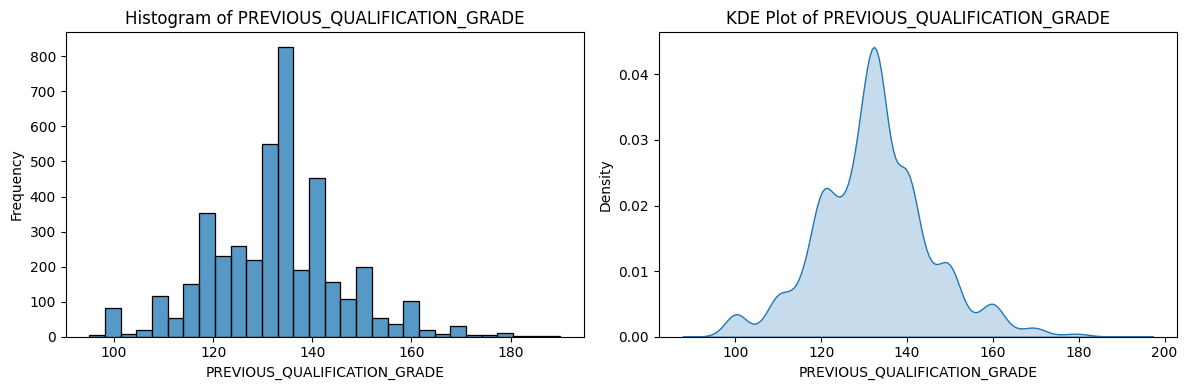

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


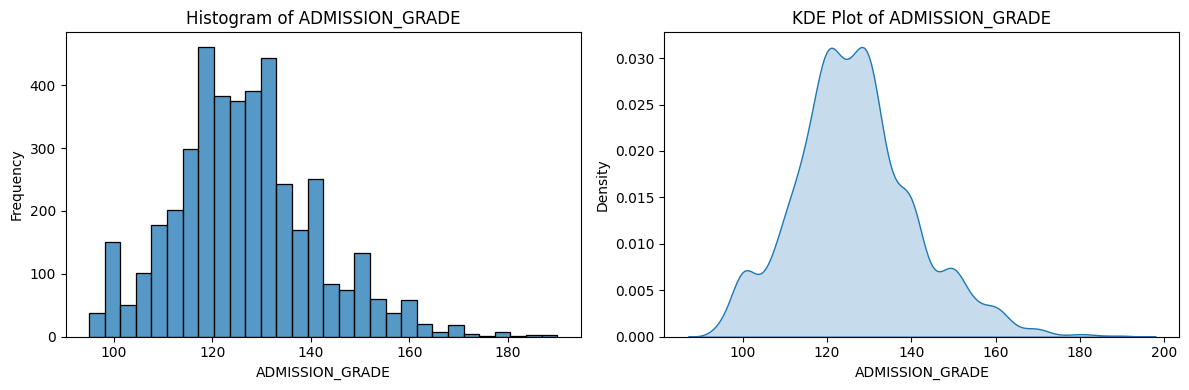

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


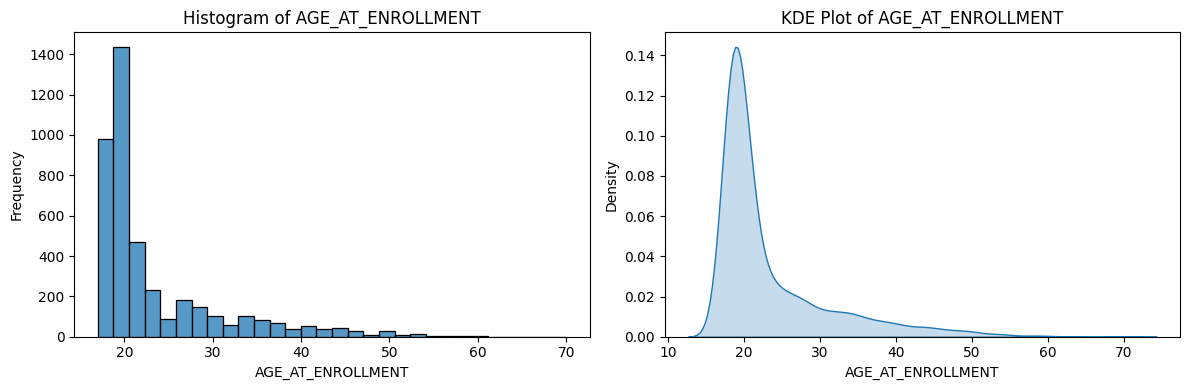

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


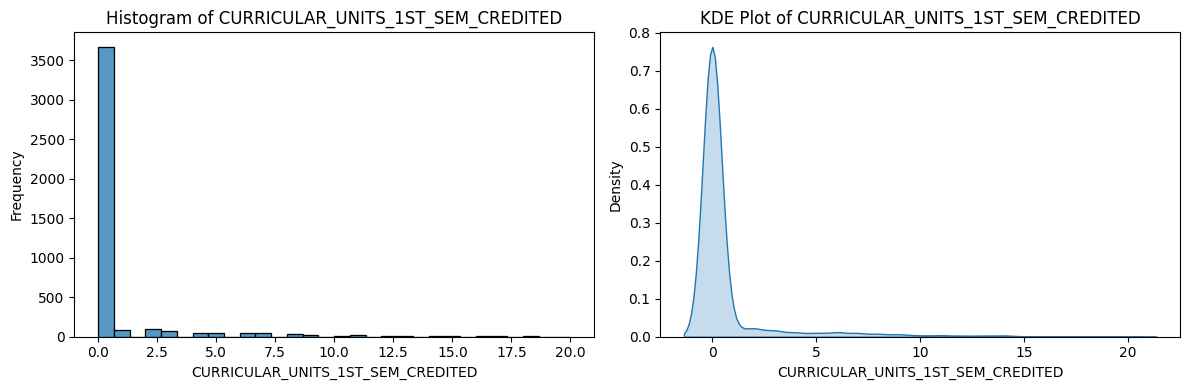

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


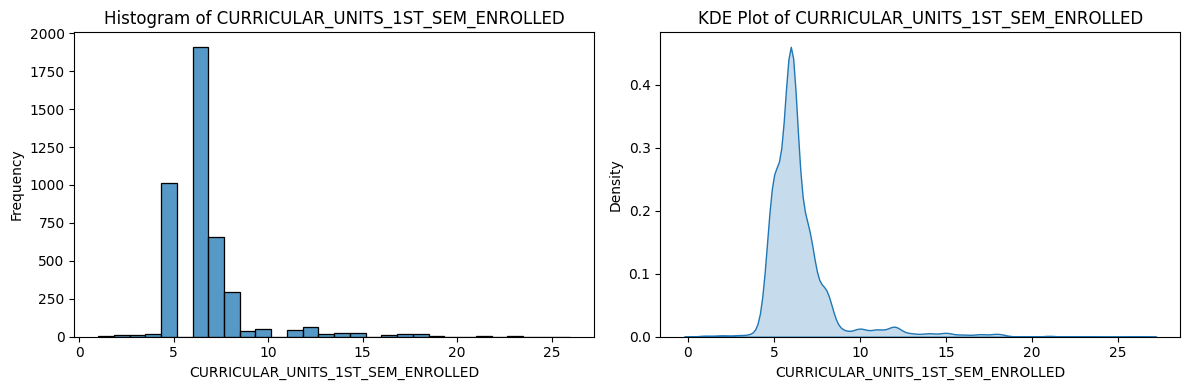

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


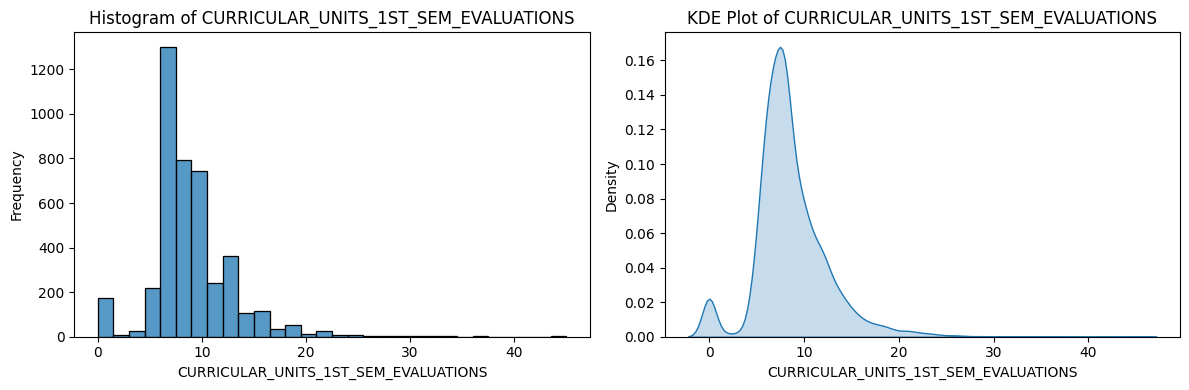

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


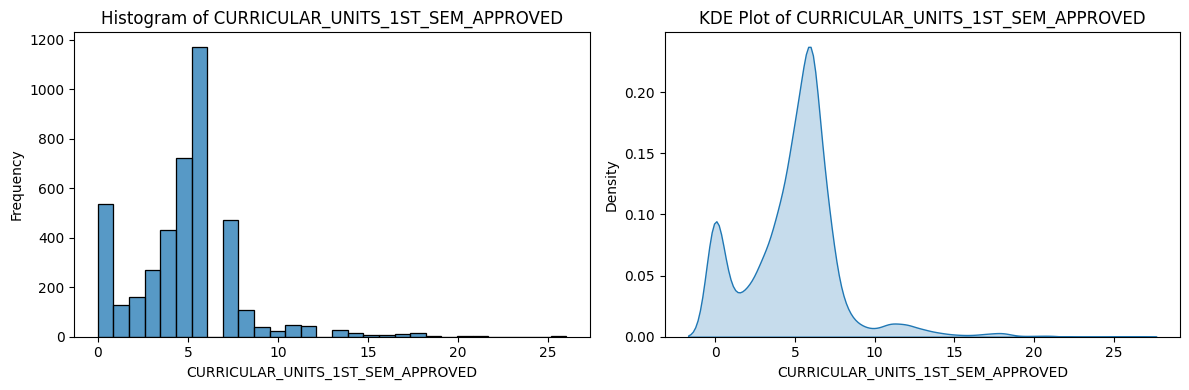

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


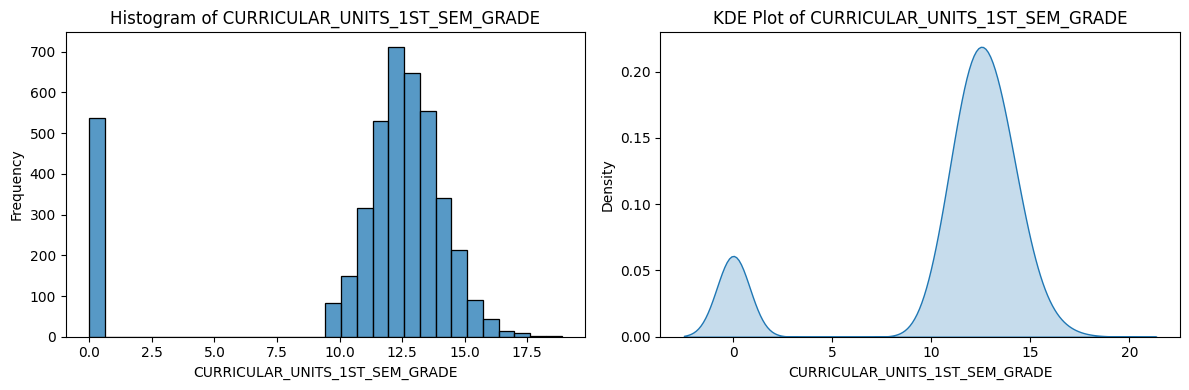

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


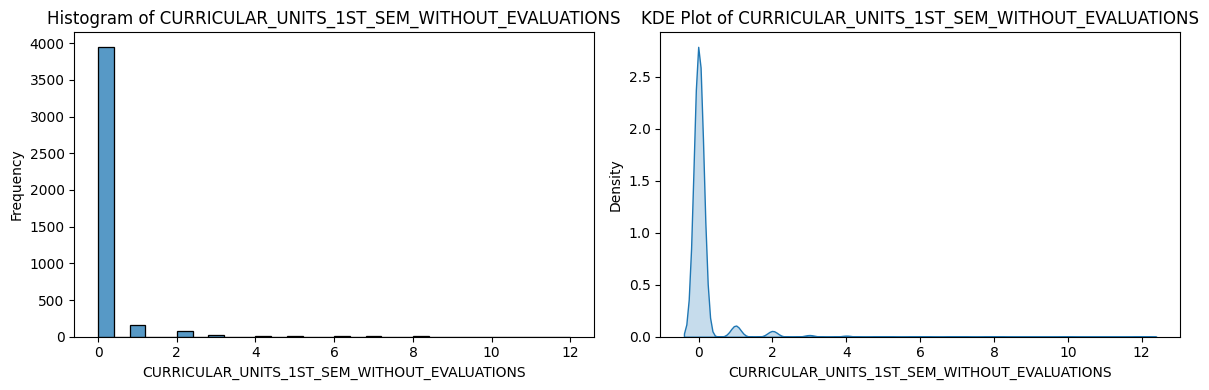

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


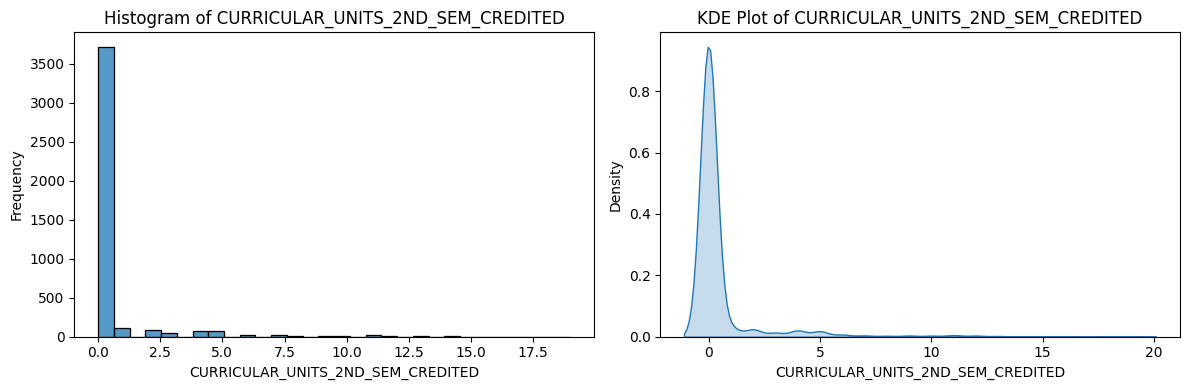

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


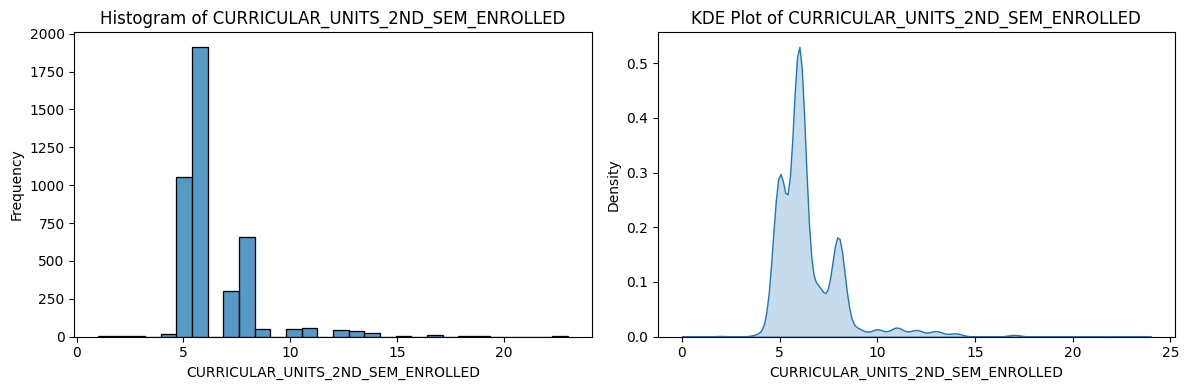

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


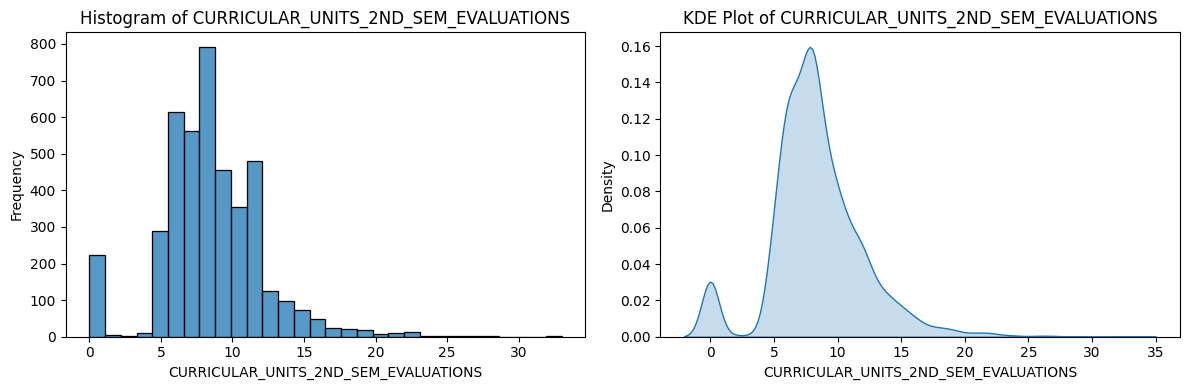

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


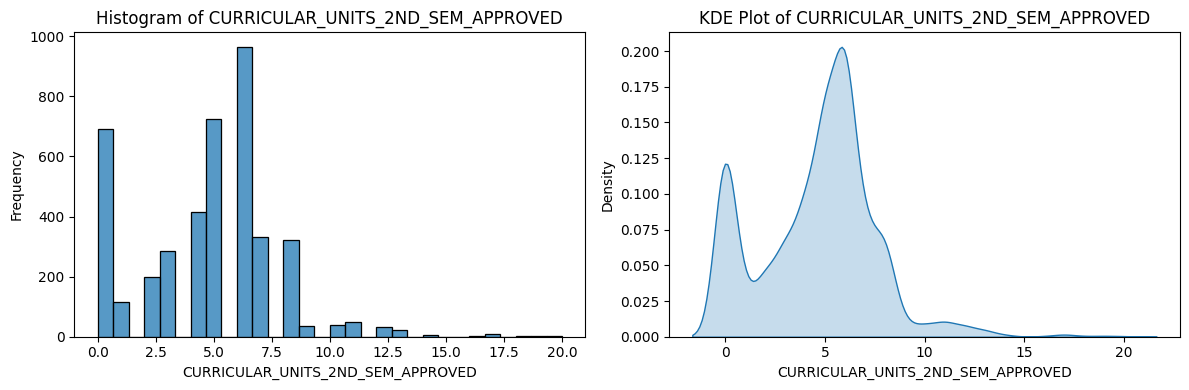

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


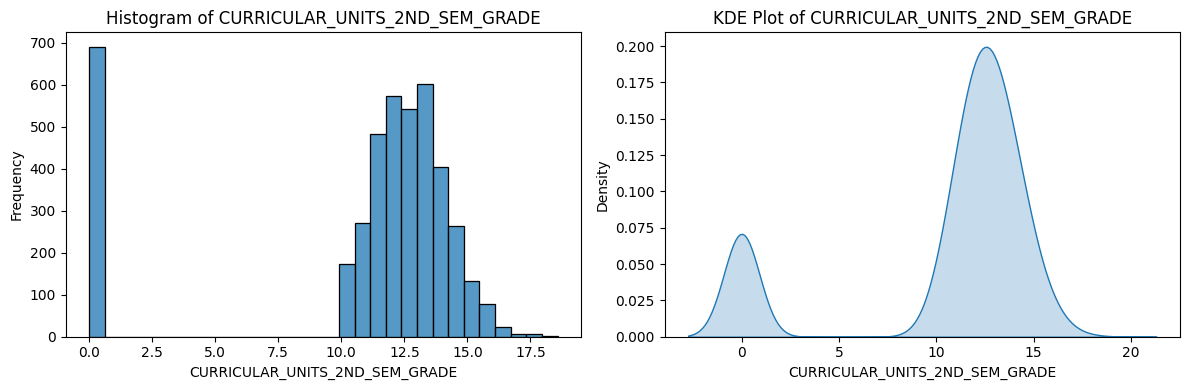

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


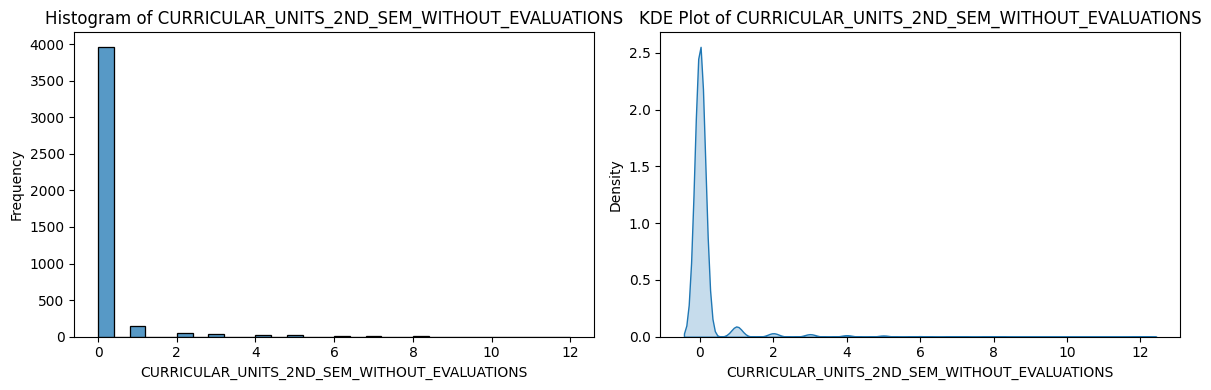

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


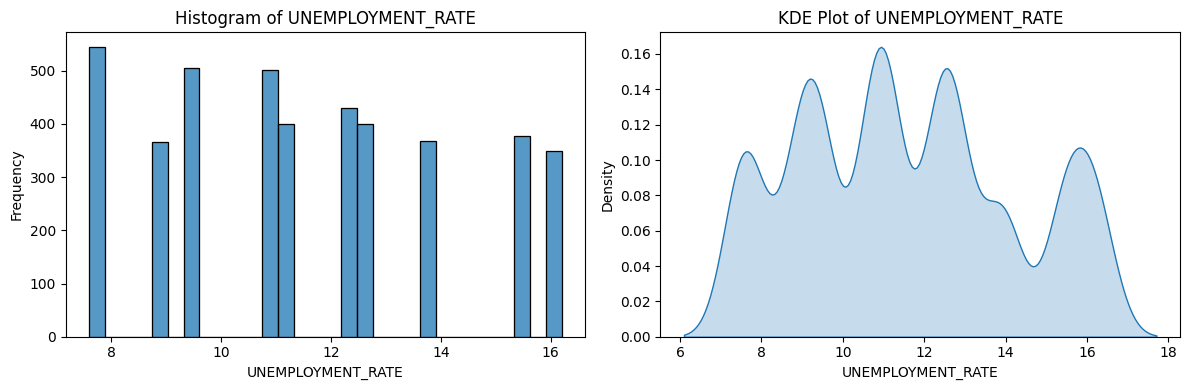

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


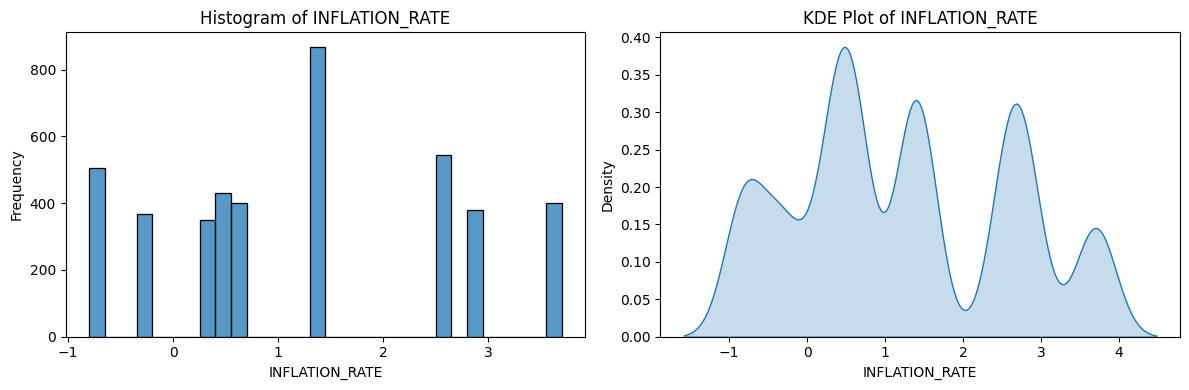

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


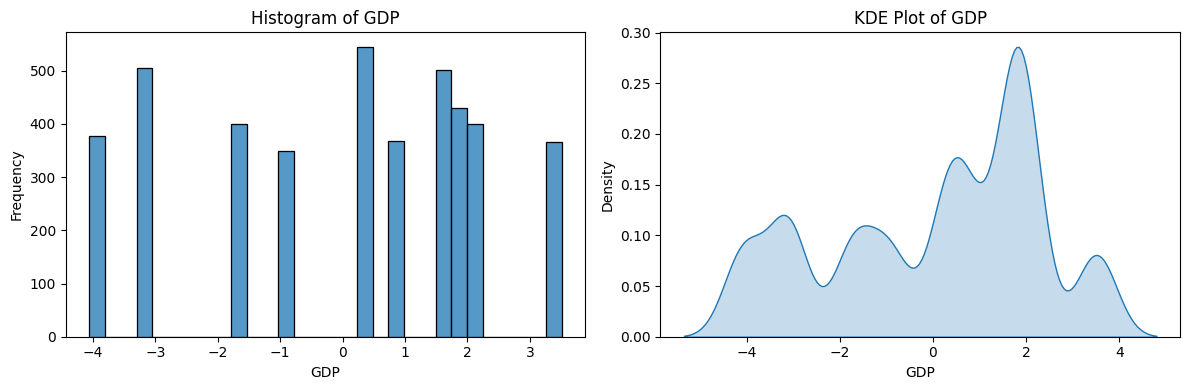

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


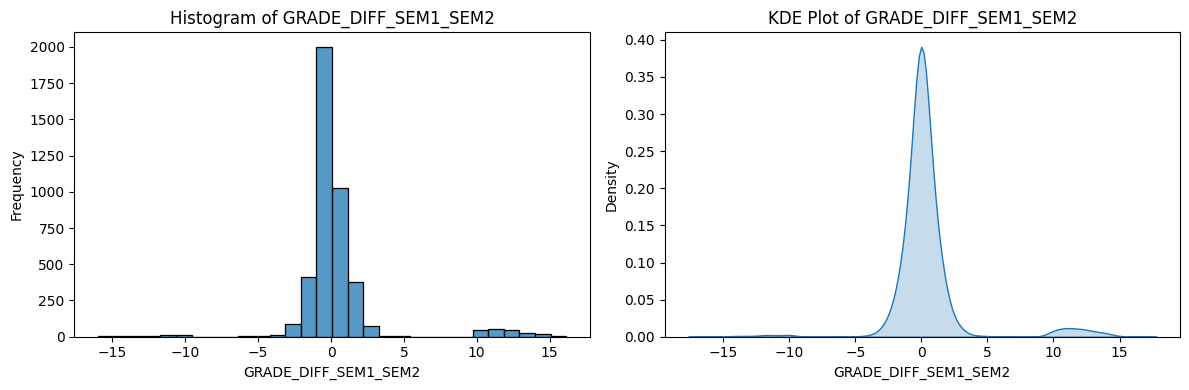

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


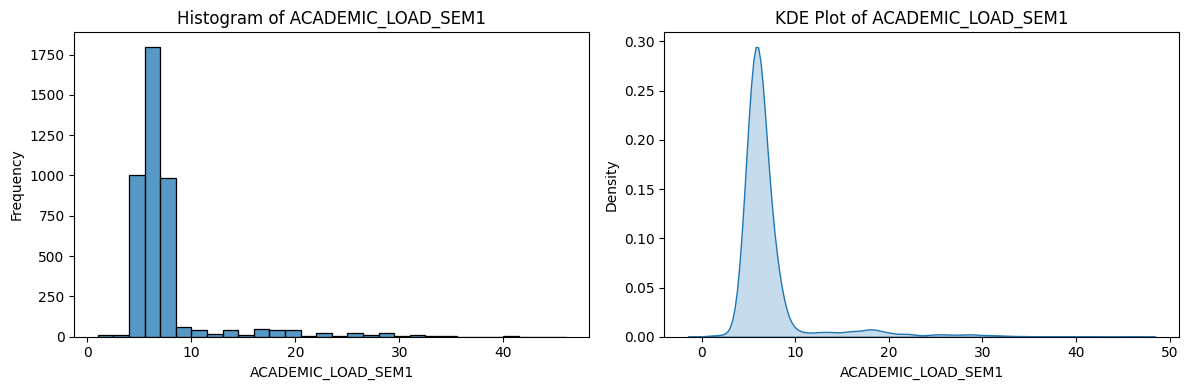

C:\Users\aidan_1k98io6\AppData\Local\Temp\ipykernel_55084\1927424024.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)


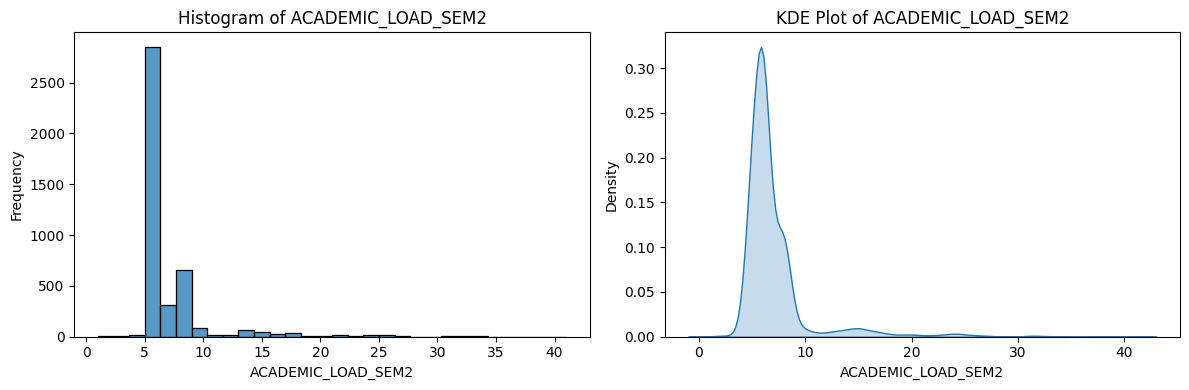

In [58]:
# Histograms and KDE Plots for Numerical Features

for col in continuous_columns:
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=False, bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    
    # KDE Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data[col], shade=True)
    plt.title(f"KDE Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()

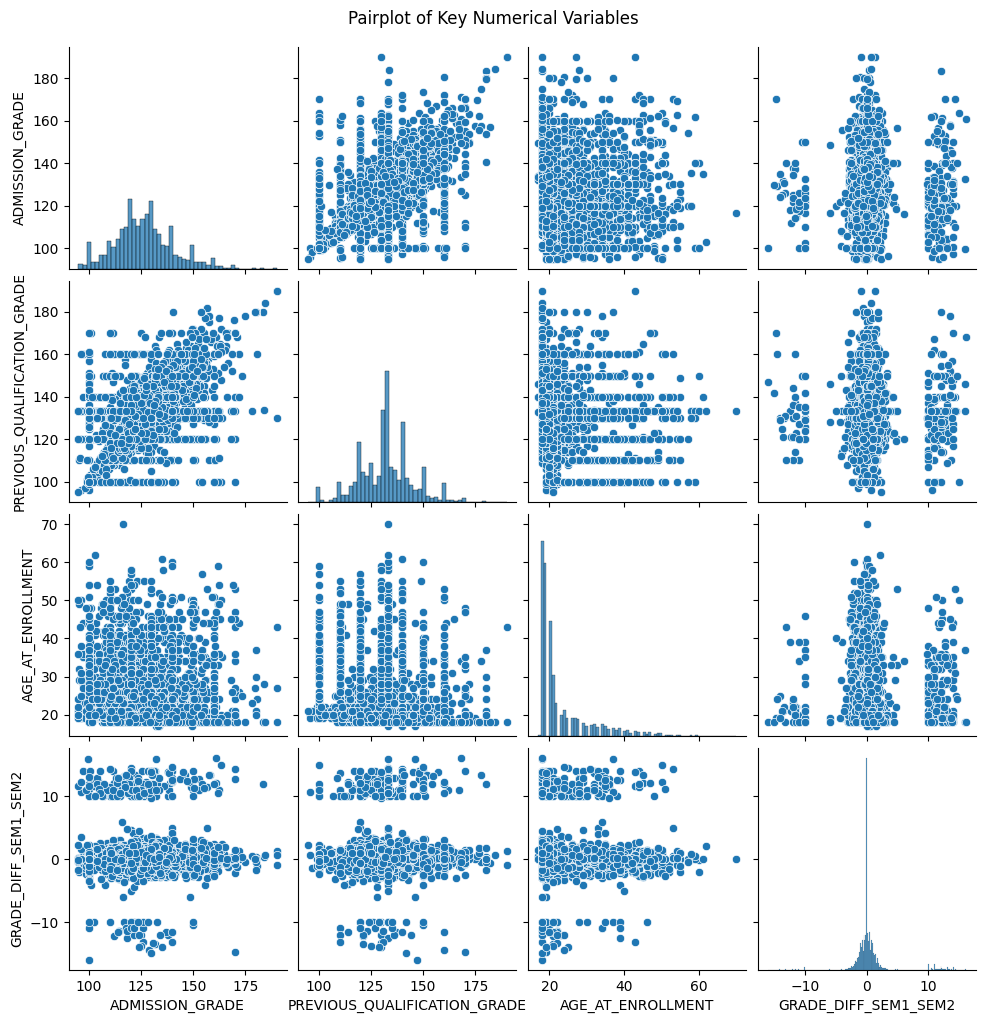

In [59]:
# Visualize relationships between key numerical variables using pairplots

# Define a subset of continuous variables to explore
key_numerical = ['ADMISSION_GRADE', 'PREVIOUS_QUALIFICATION_GRADE', 'AGE_AT_ENROLLMENT', 'GRADE_DIFF_SEM1_SEM2']

sns.pairplot(data[key_numerical])
plt.suptitle("Pairplot of Key Numerical Variables", y=1.02)
plt.show()

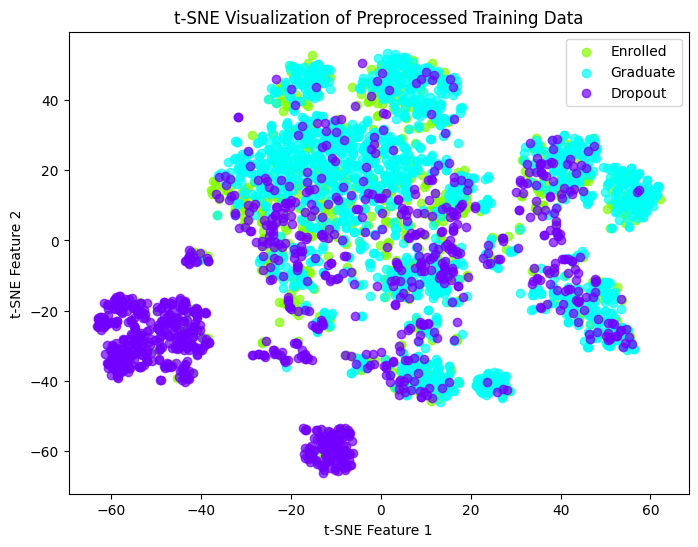

In [60]:
from sklearn.manifold import TSNE

# Perform t-SNE on the preprocessed training data
tsne = TSNE(n_components=2, random_state=99, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_preprocessed)

# Plot the t-SNE features
plt.figure(figsize=(8, 6))
unique_targets = y_train.unique()
colors = sns.color_palette("hsv", len(unique_targets))
for i, target in enumerate(unique_targets):
    idx = y_train == target
    plt.scatter(X_train_tsne[idx, 0], X_train_tsne[idx, 1], label=target, alpha=0.7, color=colors[i])
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.title("t-SNE Visualization of Preprocessed Training Data")
plt.legend()
plt.show()

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Set random seed for reproducibility
tf.random.set_seed(99)

# Determine input shape and number of classes
n_features = X_train_preprocessed.shape[1]
n_classes = len(np.unique(y_train_encoded))
print("Features:", n_features, "Classes:", n_classes)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare one-hot encoded targets using previously defined y_train_encoded and y_test_encoded
y_train_cat = to_categorical(y_train_encoded, num_classes=n_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=n_classes)

# Train the model
history = model.fit(X_train_preprocessed, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on the test set and convert predictions back to class labels
y_pred_nn = model.predict(X_test_preprocessed)
y_pred_nn_labels = label_encoder.inverse_transform(np.argmax(y_pred_nn, axis=1))
print("Sample predictions:", y_pred_nn_labels[:10])

Features: 258 Classes: 3


c:\Users\aidan_1k98io6\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4819 - loss: 1.0634 - val_accuracy: 0.7290 - val_loss: 0.7202
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6706 - loss: 0.7999 - val_accuracy: 0.7555 - val_loss: 0.6335
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7235 - loss: 0.7180 - val_accuracy: 0.7644 - val_loss: 0.5880
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7547 - loss: 0.6620 - val_accuracy: 0.7703 - val_loss: 0.5693
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7466 - loss: 0.6427 - val_accuracy: 0.7761 - val_loss: 0.5560
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7609 - loss: 0.6127 - val_accuracy: 0.7865 - val_loss: 0.5511
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7719 - loss: 0.6054 - val_accuracy: 0.7865 - val_loss: 0.5485
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7748 - loss: 0.5825 - val_accuracy: 0.7879 - val_loss

In [45]:
# # 19) Exporting the Best Model
# import joblib

# # Save the best model (XGBoost with Optuna tuning)
# joblib.dump(best_xgb_clf, 'best_xgb_model.pkl')

# # Save the preprocessing pipeline (scaler and encoder)
# preprocessing_pipeline = {
#     'scaler': scaler,
#     'encoder': encoder_cat
# }
# joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')

# print("\nBest model and preprocessing pipeline saved to disk.")

In [46]:
# to do:

# chat: https://chatgpt.com/c/67b76f9a-3ad8-800a-9e9c-b636ef2a852c
# https://chat.deepseek.com/a/chat/s/94a0cbb6-f5cc-4d86-978f-4d3d084c6f89

# ask how to improve it based on assessment brief, dataset, research papers
# use seaborn to plot the data

In [47]:
# Improvements to make:

# New Features: Captured academic trends and workload.

# Advanced Sampling: SMOTEENN for robust imbalance handling.

# XGBoost Model: Leveraged gradient boosting for better performance.

# Evaluation Metrics: Added ROC-AUC and macro F1-score.

# Interpretability: SHAP analysis to explain predictions.

# Efficient Tuning: Optuna for hyperparameter optimization

In [48]:
# validation set